<a href="https://colab.research.google.com/github/eorland/LSTM-Multistep-Prediction/blob/master/enc_dec_w_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#everything we will import to use later
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import model_from_json

%matplotlib inline

import tensorflow.compat.v1 as tf
#from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn import preprocessing
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#check our version
print(tf.VERSION)
print(tf.keras.__version__)

2.2.0-rc4
2.3.0-tf


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
def rescale(feature_data,test_targets,predictions, scaling_object,index):
    '''Flattens and rescales test and prediction data back to the original scale.
    Given that the test data and predictions do not have the same shape as the original feature data, we need 
    to "pad" these two datasets with the original column numbers of the feature data, 
    as well as have the test and prediction data occupy the same positions of their respective 
    target data columns so the rescale is done properly. 
    The below code includes one way to correctly do this padding.
    
    INPUTS: training or test feature data (it doesn't matter--we just need the same number of columns)
    test targets, and predictions, all in 3D tensor form. Also, the scaling object used 
    for the original transformation'''
    
    #flatten predictions and test data
    predict_flat = predictions.reshape(predictions.shape[0]*predictions.shape[1],predictions.shape[2])
    y_test_flat = test_targets.reshape(test_targets.shape[0]*test_targets.shape[1],test_targets.shape[2])

    #flatten the features dataframe. This has the dimensions we want.
    flattened_features = pd.DataFrame(feature_data.reshape(feature_data.shape[0]*feature_data.shape[1],
                                                           feature_data.shape[2]))
    
    #if we want to predict long sequences these will likely be longer than the length of the features.
    #we just add some zeros here to pad out the feature length to match. We'll then convert these to NaN's
    #so they're ignored. Again, we just want to inherient the
    #structure of the feature data--not the values. This is the most foolproof method
    #I've found through trial and error.
    
    if len(flattened_features) < len(y_test_flat):
        print('Length of targets exceeds length of features. Now padding...\n')
        extra_rows = pd.DataFrame(np.zeros((len(y_test_flat),flattened_features.shape[1])))
        flattened_features = pd.concat([flattened_features,extra_rows],axis=0)
        flattened_features[flattened_features==0]=np.nan
        
    #make a start column, this is the index where we begin to repopulate the target cols with the 
    #data we want to rescale
    start_col = feature_data.shape[2]-test_targets.shape[2]
    total_col = feature_data.shape[2]
    
    #make trimmed feature copies of equal length as the test data and predictions lengths, 
    #and leave out the original target data... we will replace these cols with the test and prediction data
    flattened_features_test_copy = flattened_features.iloc[:len(y_test_flat),:start_col]
    flattened_features_pred_copy = flattened_features.iloc[:len(y_test_flat),:start_col]
    #print((flattened_features_pred_copy.values))
    
    for i in range(start_col,total_col):
        #reassign targets cols
        flattened_features_test_copy[i] = y_test_flat[:,i-start_col] 
        flattened_features_pred_copy[i] = predict_flat[:,i-start_col]
        #by specifying 'i - start col', we are making sure the target column being 
        #repopulated is the matching target taken from the test data or predictions.
        #Ex: if the start col is 4, then we want to assign the first column of the test and pred data--
        #this is index 0, and 4-4 = 0.
        
    #We now have the correct dimensions, so we can FINALLY rescale
    y_test_rescale = scaling_object.inverse_transform(flattened_features_test_copy)
    preds_rescale = scaling_object.inverse_transform(flattened_features_pred_copy)
    
    #just grab the target cols.
    y_test_rescale = y_test_rescale[:,start_col:]
    preds_rescale = preds_rescale[:,start_col:]
    
    preds_rescale = pd.DataFrame(preds_rescale,index=index)
    y_test_rescale = pd.DataFrame(y_test_rescale,index=index)
    
    
     #before we return the dataframes, check and see if predictions or test data have null values.
    if preds_rescale.isnull().values.any()==True:
        print('Keras predictions have NaN values present. Deleting...')
        print('Current shape: ' + str(pred_rescale.shape))
        nans = np.argwhere(np.isnan(preds_rescale.values)) #find nulls
        #delete make sure values are deleted from both
        y_test_rescale = np.delete(y_test_rescale.values, nans,axis=0)
        preds_rescale = np.delete(preds_rescale.values, nans, axis=0)
        index = np.delete(index, nans, axis=0)
        #turn back into dataframe in case next condition is also true
        preds_rescale = pd.DataFrame(preds_rescale, index=index) 
        y_test_rescale = pd.DataFrame(y_test_rescale, index=index)
        print('New Shape: ' + str(preds_rescale.shape))
        
    
    if y_test_rescale.isnull().values.any()==True:
        print('Test data still have NaN values present. Deleting...')
        print('Current shape: ' + str(y_test_rescale.shape))
        nans = np.argwhere(np.isnan(y_test_rescale.values)) 
        #same as above
        y_test_rescale = np.delete(y_test_rescale.values, nans,axis=0)
        preds_rescale = np.delete(preds_rescale.values, nans, axis=0)
        index = np.delete(index, nans, axis=0)
        # make into DataFrame this time to guarantee the below return statement won't spit an error
        y_test_rescale = pd.DataFrame(y_test_rescale,index=index)
        preds_rescale = pd.DataFrame(preds_rescale,index=index)
        print('New shape: ' + str(y_test_rescale.shape))
    
    print('test data new shape: ' + str(y_test_rescale.shape))
    print('prediction new shape: ' + str(preds_rescale.shape))
    return y_test_rescale,preds_rescale

In [0]:
def lstm_prep(data_index,data,ntargets,ninputs,noutputs=1,show_progress=False):
    '''Prepares and reshapes data for use with an LSTM. Outputs features, targets,
    and the original data indices of your target values for visualization later. Requires that 
    the targets are the last N columns in your dataset.
    
    NOTE: The applies a moving window approach at intervals of the output steps, such that 
    you group the previous timesteps of inputs for your features (whatever length you choose),set the next 
    X timesteps of target values as outputs (again, whatever you want), and then move the window X (noutputs)
    timesteps in the future to repeat the process. Analogous to a cnn kernal with a stride equal to the output length. 
    I wrote this to automate and quickly change between varying input and output sequence lengths, 
    but wanted to avoid overlapping values typical in a moving window approach. 
    Having these non-overlapping values just makes plotting easier. 
    So far I have yet to see a need for more samples, which I understand is why the 
    moving window approach is typicallyimplemented.'''
    
    target_data = data[:,-ntargets:]
    features = np.empty((ninputs,data.shape[1]), int)
    targets = np.empty((noutputs,ntargets),int)
    for i in range(ninputs,(len(data)-noutputs),noutputs): 
        if show_progress==True:
            print('current index: '+str(i))
        
        temp_feature_matrix = data[(i-ninputs):i]
        temp_target_matrix = target_data[(i):(i+noutputs)]
        
        features = np.vstack((features, temp_feature_matrix))
        targets = np.vstack((targets,temp_target_matrix))
    
    last_index = i+noutputs
    features = features.reshape((int(features.shape[0]/ninputs),ninputs,features.shape[1]))
    targets = targets.reshape(int(targets.shape[0]/noutputs),noutputs,targets.shape[1])
    
    target_indices = data_index[ninputs:last_index]
    
    return features[1:], targets[1:], target_indices

def rectify_cnn_data(predictions, targets, num_targets, noutputs):
    preds = np.empty((noutputs,num_targets), int)
    tests = np.empty((noutputs,num_targets), int)
    for row in range(0,predictions.shape[0]):
        pred_t = np.transpose(np.array(np.split(predictions[row],num_targets)))
        #print('preds: '+ str(pred_t))
        preds = np.vstack((preds, pred_t))

        test_t = np.transpose(np.array(np.split(targets[row],num_targets)))
        #print('tests: '+ str(test_t))
        tests = np.vstack((tests, test_t))
    #print(preds)
    return preds[noutputs:], tests[noutputs:]


def mse_nan(y_true, y_pred):
    masked_true = tf.where(tf.is_nan(y_true), tf.zeros_like(y_true), y_true)
    masked_pred = tf.where(tf.is_nan(y_true), tf.zeros_like(y_true), y_pred)
    return K.mean(K.square(masked_pred - masked_true), axis=-1)

def mae_nan(y_true, y_pred):
    masked_true = tf.where(tf.is_nan(y_true), tf.zeros_like(y_true), y_true)
    masked_pred = tf.where(tf.is_nan(y_true), tf.zeros_like(y_true), y_pred)
    return K.mean(abs(masked_pred - masked_true), axis=-1)


def evaluate_forecasts(actual, predicted): #from Jason Brownlee's blog
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        #print('mse: '+ str(mse))
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    
    print(scores)
    return score, scores

def threshold_rmse_eval(tests, preds, threshold):
    pred_pos_all = []
    y_pos_all = []
    rmse = []
    for i in range(preds.shape[1]):
        #grab individual cols
        data_slice_test = tests[:,i]
        data_slice_pred = preds[:,i]
        
        
        #This avoids a warning for the np.where query a couple of lines down...
        test_nans = np.where(np.isnan(data_slice_test)) #find nans and replace with dummy value. 
        tests[test_nans] = threshold*100
        
        #find all values greater than or equal to your threshold value
        pos_test = np.where(data_slice_test >= threshold)
        y_pos = data_slice_test[pos_test] #get those values from the test data
        pred_pos = data_slice_pred[pos_test] #get the equivalent values from the predictions
        
        #calculate mse, rmse
        mse = mean_squared_error(y_pos, pred_pos)
        rmse_val = np.sqrt(mse)
        
        #append all values to our respective lists
        rmse.append(rmse_val)
        y_pos_all.append(y_pos)
        pred_pos_all.append(pred_pos)
    
    print('per target rmse: ' + str(rmse))
    
    
    #make a list of rmse per datapoint
    diff_array = np.empty((1,tests.shape[1]),int)
    for row in range(tests.shape[0]):
        diffs = []
        for col in range(tests.shape[1]):
            #print(tests[row,col])
            #print(preds[row,col])
            diff = tests[row,col] - preds[row, col]
            diffs.append(diff)
        diffs = np.array(diffs)
        diff_array = np.vstack((diff_array,diffs))
    
    return y_pos_all, pred_pos_all, rmse, diff_array[1:]


def naive_forecast(test_data,backsteps,forward_steps):
    back_array = np.arange(0,backsteps+1)
    naive_preds = np.zeros(shape=(test_data.shape[0],test_data.shape[1]))
    for row in range(0,test_data.shape[0],forward_steps):
        #print(row)
        for col in range(test_data.shape[1]):
            if row in back_array:
                naive_preds[row,col] = test_data[row,col]
            else:
                naive_preds[row,col] = np.mean(test_data[(row-backsteps):row,col])
                for i in range(1,forward_steps):
                    row_index = row+i
                    if row_index == len(test_data):
                        break
                    else:
                        naive_preds[(row_index),col] = np.mean(naive_preds[(row_index-backsteps):row_index,col])

    return naive_preds

def add_max_rainfall(data,interval,rain_col,noise=False):
    '''takes times series data as input, and calculates the maximum and total rainfall values 
    for a fixed interval, based on the column index of your rainfall (rain_col).

    This function assumes you are using pandas, but can be modified for numpy arrays, which will perform faster
    for larger datasets'''
    rain_total = np.array(np.zeros(len(data)))
    rain_max = np.array(np.zeros(len(data)))
    
    if noise==True:
      for row in range(0,len(data),1):
        if row >= (len(data) - interval):
            rain_total[row] = (np.sum(data.iloc[row:len(data),rain_col]))*np.random.randint(0.75,1.25)
            rain_max[row] = (max(data.iloc[row:len(data),rain_col]))*np.random.randint(0.75,1.25)
            
        rain_total[row] = np.sum(data.iloc[row:row+interval,rain_col])*np.random.randint(0.75,1.25)
        rain_max[row] = max(data.iloc[row:row+interval,rain_col])*np.random.randint(0.75,1.25)



    else:
      for row in range(0,len(data),1):
          if row >= (len(data) - interval):
              rain_total[row] = np.sum(data.iloc[row:len(data),rain_col])
              rain_max[row] = np.nanmax(data.iloc[row:len(data),rain_col])
          
          rain_total[row] = np.sum(data.iloc[row:row+interval,rain_col])
          rain_max[row] = np.nanmax(data.iloc[row:row+interval,rain_col])

    data[str(interval)+'hr_total_rfall'] = rain_total
    data[str(interval)+'hr_max_rfall'] = rain_max
    
    return data

In [0]:
from google.colab import files
uploaded = files.upload()

Saving SP1.txt to SP1.txt


In [0]:
ocr = pd.read_csv('SP1.txt',index_col='timestamp_utc',sep='\t')
datetime = pd.to_datetime(ocr.index,dayfirst=False)
ocr = ocr.set_index(datetime)
mask_cols = ['porePressure_63cm_kPa','porePressure_113cm_kPa','porePressure_244cm_kPa']
ocr[mask_cols] = ocr[mask_cols].mask(ocr[mask_cols] < -14)

In [0]:
ocr['date'] = ocr.index.values.astype(float)

In [0]:
ocr.columns

Index(['RG_mm', 'VWC_20cm', 'VWC_50cm', 'VWC_93cm', 'porePressure_63cm_kPa',
       'porePressure_113cm_kPa', 'porePressure_244cm_kPa', 'date'],
      dtype='object')

In [0]:
# add in forecasted rainfall
# this will take a while
for i in range(2,38,2):
  ocr = add_max_rainfall(ocr,i,0,noise=False)

In [0]:
# list relevant cols
ocr.columns

Index(['RG_mm', 'VWC_20cm', 'VWC_50cm', 'VWC_93cm', 'porePressure_63cm_kPa',
       'porePressure_113cm_kPa', 'porePressure_244cm_kPa', 'date',
       '2hr_total_rfall', '2hr_max_rfall', '4hr_total_rfall', '4hr_max_rfall',
       '6hr_total_rfall', '6hr_max_rfall', '8hr_total_rfall', '8hr_max_rfall',
       '10hr_total_rfall', '10hr_max_rfall', '12hr_total_rfall',
       '12hr_max_rfall', '14hr_total_rfall', '14hr_max_rfall',
       '16hr_total_rfall', '16hr_max_rfall', '18hr_total_rfall',
       '18hr_max_rfall', '20hr_total_rfall', '20hr_max_rfall',
       '22hr_total_rfall', '22hr_max_rfall', '24hr_total_rfall',
       '24hr_max_rfall', '26hr_total_rfall', '26hr_max_rfall',
       '28hr_total_rfall', '28hr_max_rfall', '30hr_total_rfall',
       '30hr_max_rfall', '32hr_total_rfall', '32hr_max_rfall',
       '34hr_total_rfall', '34hr_max_rfall', '36hr_total_rfall',
       '36hr_max_rfall'],
      dtype='object')

In [0]:
# rearrange cols
ocr = ocr.loc[:,['date', 'RG_mm','2hr_total_rfall', '2hr_max_rfall', '4hr_total_rfall', '4hr_max_rfall',
       '6hr_total_rfall', '6hr_max_rfall', '8hr_total_rfall', '8hr_max_rfall',
       '10hr_total_rfall', '10hr_max_rfall', '12hr_total_rfall',
       '12hr_max_rfall', '14hr_total_rfall', '14hr_max_rfall',
       '16hr_total_rfall', '16hr_max_rfall', '18hr_total_rfall',
       '18hr_max_rfall', '20hr_total_rfall', '20hr_max_rfall',
       '22hr_total_rfall', '22hr_max_rfall', '24hr_total_rfall',
       '24hr_max_rfall', '26hr_total_rfall', '26hr_max_rfall',
       '28hr_total_rfall', '28hr_max_rfall', '30hr_total_rfall',
       '30hr_max_rfall', '32hr_total_rfall', '32hr_max_rfall',
       '34hr_total_rfall', '34hr_max_rfall', '36hr_total_rfall',
       '36hr_max_rfall', 'VWC_20cm', 'VWC_50cm', 'VWC_93cm',
       'porePressure_63cm_kPa', 'porePressure_113cm_kPa',
       'porePressure_244cm_kPa']]

In [0]:
# scale data
data = ocr
data_scaling = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(data.iloc[:,:])
data_scaled = pd.DataFrame(data_scaling.transform(data.iloc[:,:]),index=ocr.index)
data_scaled_df = data_scaled.fillna(-1)

In [0]:
# finally, prepare features and targets
features, targets, target_indices = lstm_prep(data_scaled_df.index.values,data_scaled_df.values,3,36,36)

In [0]:
# create bounds for the prediction intervals
intervals = np.zeros(len(target_indices))
for i in range(0,len(intervals),targets.shape[1]):
    intervals[i]=1

intervals[intervals==0] = np.nan

binary_indices = np.copy(target_indices)

for i in range(0,len(binary_indices),36):
    binary_indices[i]=np.datetime64("NaT")

In [0]:
# set -1s to nan to be ignored
targets[targets==-1]=np.nan

In [0]:
# split training/testing data based on water years 1&2
split = 0.7
train_features = features[:int((len(features)*split))]
test_features = features[int((len(features)*split)):]

train_targets = targets[:int((len(features)*split))]
test_targets = targets[int((len(features)*split)):]
test_indices = target_indices[-test_targets.shape[0]*test_targets.shape[1]:]

In [0]:
# if you want to subsample the training data to test minimum requirements
# otherwise skip this
train_features_reduced, _ , train_targets_reduced, _ = train_test_split(train_features, train_targets, 
                                                                       test_size=0.86, random_state=42,shuffle=True)

The below model is inspired by and adapted from: https://github.com/LukeTonin/keras-seq-2-seq-signal-prediction

Create our Encoder:

In [0]:
# Define an input shape. This is the tensor shape our model expects from now on.
# This is essential for a stateful model
batch = None
n_units = 32

encoder_inputs = Input(batch_input_shape=(batch,train_features.shape[1],train_features.shape[2]))

encoder_lstm1 = LSTM(n_units, return_state=True,stateful=False,return_sequences=True) # define encoder
encoder_lstm2 = LSTM(n_units, return_state=True,stateful=False,return_sequences=True)
# connect encoding layer to our inputs, return all states
int_enc_outputs = encoder_lstm1(encoder_inputs)
encoder_outputs, state_h, state_c = encoder_lstm2(int_enc_outputs) 

encoder_states = [state_h, state_c]

In [0]:
# to experiment with a bidirectional LSTM, you can use this code block instead
# but you will have to double the units in the decoder accordingly
encoder_lstm = Bidirectional(LSTM(units=n_units, return_sequences=True, return_state=True)) # Bidirectional
encoder_outputs, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm((encoder_inputs))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])

encoder_states = [state_h, state_c]

Create Decoder:

In [0]:
# Define inputs to the decoder.
decoder_inputs = Input(batch_input_shape=(batch,None,train_targets.shape[2]))

# Create Decoder...
decoder_lstm = (LSTM(n_units, return_state=True, return_sequences=True,stateful=False))
# Important step: connect Decoder to our input layers and use the hidden and cell states 
# from the encoder to instantiate this layer

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

#create attention layer
# ----------------------
attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
attention2 = Activation('softmax')(attention)

context = dot([attention2, encoder_outputs], axes=[2,1])
decoder_combined_context = concatenate([context, decoder_outputs])
# ----------------------

decoder_dense1 = (Dense(50, activation='tanh'))
dropout = Dropout(0.5)
decoder_dense2 = Dense(train_targets.shape[2],activation='linear')

dense1 = decoder_dense1(decoder_combined_context)
drop = dropout(dense1)

decoder_outputs = decoder_dense2(drop)

In [0]:
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

model.compile(optimizer='adam',
             loss=mse_nan,
             metrics=[mse_nan])

In [0]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 36, 44)]     0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 36, 32), (No 9856        input_6[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 36, 32), (No 8320        lstm_6[0][0]                     
                                                                 lstm_6[0][1]               

In [0]:
#define inference ('inf') model:
encoder_model = Model(encoder_inputs, [encoder_outputs,encoder_states]) 
# ^^^ set up a separate encoding model. This just outputs our encoder states

inf_encoder_outputs, inf_encoder_states = encoder_model(encoder_inputs)

decoder_state_input_h = Input(shape=(n_units,)) # define shape of hidden state
decoder_state_input_c = Input(shape=(n_units,)) # same thing here for cell state
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# ^^^ set as state shapes, which tells our decoder to accepts inputs states of the specificed size

# create our decoding layer. accepts same shape as decoder inputs and encoder states
inf_decoder_outputs, inf_state_h, inf_state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

# save decoder output states. We'll use these as the input states for our decoder for predicting each next timestep
# after the initial input of our encoder states
decoder_states = [inf_state_h, inf_state_c]

inf_attention = dot([inf_decoder_outputs, inf_encoder_outputs], axes=[2, 2])
inf_attention2 = Activation('softmax')(inf_attention)

inf_context = dot([inf_attention2, inf_encoder_outputs], axes=[2,1])
inf_decoder_combined_context = concatenate([inf_context, inf_decoder_outputs])


inf_dense1 = decoder_dense1(inf_decoder_combined_context)
inf_drop = dropout(inf_dense1)

inf_final_outputs = decoder_dense2(inf_drop)
# finally, instantiate our decoder model. Inputs are the original sequence + the encoder states. 
# outputs: sequence prediction + the states used for the decoder
decoder_model = Model([encoder_inputs,decoder_inputs] + decoder_states_inputs, [inf_final_outputs]+decoder_states)

In [0]:
decoder_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 36, 44)]     0                                            
____________________________________________________________________________________________

In [0]:
# Let's define a small function that predicts based on the trained encoder and decoder models
# Function also adapted from https://github.com/LukeTonin/keras-seq-2-seq-signal-prediction
def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict, 
            num_features_to_predict, batch_size=None):
    """Predict time series with encoder-decoder.
    
    Uses the encoder and decoder models previously trained to predict the next
    num_steps_to_predict values of the time series.
    
    Arguments
    ---------
    x: input time series of shape (batch_size, input_sequence_length, input_dimension).
    encoder_predict_model: The Keras encoder model.
    decoder_predict_model: The Keras decoder model.
    num_steps_to_predict: The number of steps in the future to predict
    num_features_to_predict: The number of features we want to predict per timestep
    
    Returns
    -------
    y_predicted: output time series for shape (batch_size, target_sequence_length,
        ouput_dimension)
    """
    y_predicted = []

    # Encode the values as a state vector
    enc_outputs_and_states = encoder_predict_model.predict(x,batch_size=batch)
    #print(len(enc_outputs_and_states))

    # The states must be a list
    if not isinstance(enc_outputs_and_states, list):
        enc_outputs_and_states = [enc_outputs_and_states]

    enc_outputs = enc_outputs_and_states[0]
    states = enc_outputs_and_states[1:]
    #decoder_input = np.zeros((x.shape[0], 1, num_features_to_predict))
    decoder_input = x[:,-1:,-num_features_to_predict:] 
    # '-num_features_to_predict:' assumes the targets are the final columns

    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [x, decoder_input] + states, batch_size=batch)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)


    return np.concatenate(y_predicted, axis=1)
    

In [0]:
for i in range(2000):
    print('epoch: '+str(i))
    model.fit([train_features,train_features[:,-36:,-3:]], train_targets, 
              epochs=1, batch_size=100, verbose=0, shuffle=True)
    #model.reset_states()

Evaluate Model

In [0]:
predictions = predict(test_features, encoder_model, decoder_model, 
                      num_steps_to_predict=train_targets.shape[1], num_features_to_predict=train_targets.shape[2],
                     batch_size=None)

In [0]:
tests, preds = rescale(test_features, test_targets, predictions, data_scaling, test_indices)
score, scores = evaluate_forecasts(tests.values, preds.values)

#generate naive predictions
naive_preds = naive_forecast(tests.values,1,24)
naive_preds = pd.DataFrame(naive_preds, index=tests.index)

#evaluate model performance on RMSE of just hazardous pore pressure values
print("\nLSTM Performance:")
y_pos, pred_pos, rmse, diff_array = threshold_rmse_eval(tests.values,preds.values,-0.5)
print("Naive Comparison:")
y_pos_naive, naive_pos, naive_rmse, naive_diff_array = threshold_rmse_eval(tests.values,naive_preds.values,-0.5)

Test data still have NaN values present. Deleting...
Current shape: (7884, 3)
New shape: (6268, 3)
test data new shape: (6268, 3)
prediction new shape: (6268, 3)
[0.7944141615003871, 0.5427275657590844, 0.4418120297301256]

LSTM Performance:
per target rmse: [0.9510318915451141, 0.6910694232942018, 0.5166702276779271]
Naive Comparison:
per target rmse: [1.4094209756375715, 1.123661870849056, 0.8661832724882542]


1
2
3


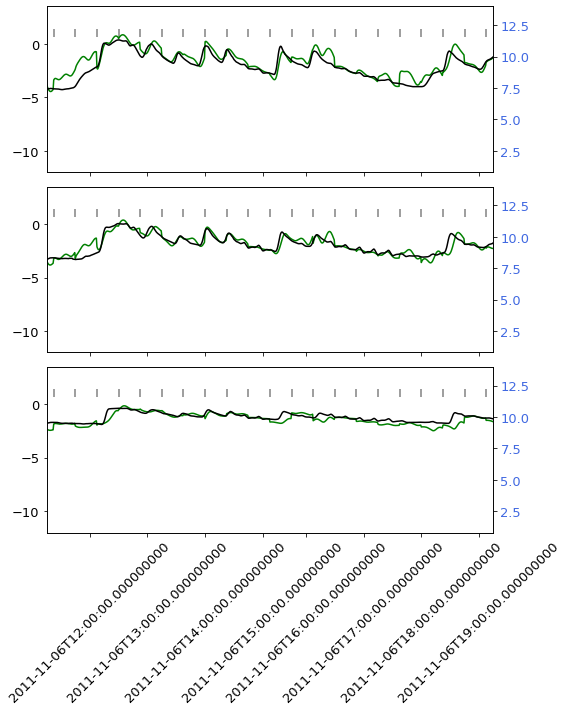

In [0]:
import matplotlib.lines as mlines

start = pd.to_datetime('2012-01-14')
end = pd.to_datetime('2012-02-14')
#messy plot of rainfall and test data/predictions. I've been messing with the y axis range to help clean it up
col_list = ['Soil Matric Potential',
       'Pore Water Pressures - 113cm', 'Pore Water Pressures - 244cm']
fig, ax = plt.subplots(3,1,figsize=(8,10),sharex=True)
i = 1
for col in col_list:
    while i < (len(col_list)+1):
        print(i)
        ax1 = ax[i-1]
        ax1.plot(preds.iloc[:, i-1],c='g', label='Predictions')
        ax1.plot(tests.iloc[:, i-1],c='k', label='Test Data')
        #ax1.plot(naive_preds.iloc[:, i-1],c='b', label='Naive Predictions')
        ax1.scatter(target_indices,intervals,c='k',marker='|',s=50,alpha=0.5)
        ax1.set_xlim(start,end)
        ax1.set_ylim(-12,3.5)
        #ax1.set_ylabel('Suction (kPa)')
        ax1.xaxis.set_visible(True)
        #plt.legend(handles=[green_line,black_line],bbox_to_anchor=(-0.05, 1))
        ax1.set_xticklabels(test_indices,rotation = 45)
        ax1.tick_params(axis='both', labelcolor='k',labelsize=13)
        
        
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'royalblue'
        #ax2.set_ylabel('Rainfall (mm)', color=color)  # we already handled the x-label with ax1
        #ax2.bar(preds.index, ocr.loc[preds.index,'RG_mm'], color=color,alpha=0.8,width=0.2)
        ax2.tick_params(axis='y', labelcolor=color,labelsize=13)
        ax2.set_ylim(0.8,14)
        
        #plt.plot(ocr.iloc[test_indices,0])
        #plt.plot(naive_preds.iloc[:, i-1], label='Naive Predicitons')
        #plt.title((col_list[i-1]))
        green_line = mlines.Line2D([], [], color='g', marker='',
                          markersize=15, label='Predictions')
        black_line = mlines.Line2D([], [], color='k', marker='',
                          markersize=15, label='Observed Pressures')
        vert = mlines.Line2D([], [], color='k', marker='|',alpha=0.5,
                          markersize=15, label='Prediction Interval (36hr)')
        vert.set_linestyle('')
        #if i ==1:
            #plt.legend(handles=[green_line,black_line,vert],loc='upper center',
             #        fontsize='small',bbox_to_anchor=(0.52,1.01),ncol=3,
              #       markerscale=1.3,frameon=False)
            #plt.title((col_list[i-1]))
        #plt.setp(ax1.get_xticklabels(True,"major"), visible=True)
        
        #plt.ylim(-10,2)
        #plt.legend()
        i += 1
        
        
        


plt.tight_layout()

#plt.savefig('36hr_36_24_d75dr50_JF_UPDATE.svg',dpi=300,frameon=True)
plt.show()

LinregressResult(slope=1.1365812914422624, intercept=0.40878898255905805, rvalue=0.9716398204286968, pvalue=0.0, stderr=0.0034943651177795102)
1.1365812914422624
LinregressResult(slope=0.9901123212063773, intercept=-0.12098055668556595, rvalue=0.9408548459398747, pvalue=0.0, stderr=0.004504252781928732)
0.9901123212063773
LinregressResult(slope=1.0582515139794821, intercept=-0.10388030128207748, rvalue=0.9591500125357872, pvalue=0.0, stderr=0.00394309259653622)
1.0582515139794821


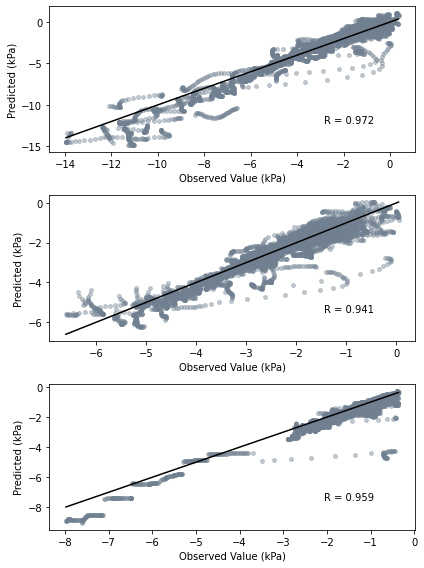

In [0]:
from sklearn.metrics import r2_score
from scipy.stats import linregress


col_list = ['Pore Water Pressures - 63cm',
       'Pore Water Pressures - 113cm', 'Pore Water Pressures - 244cm']
fig, ax = plt.subplots(3,1,figsize=(6,8),sharex=False)
i = 1
for col in col_list:
    while i < (len(col_list)+1):
      x = np.linspace(np.nanmin(tests.iloc[:,i-1]),np.nanmax(tests.iloc[:,i-1]),100)
      y = x
      ax1 = ax[i-1]
      ax1.plot(x,y,c='k')
      ax1.scatter(tests.iloc[:,i-1],preds.iloc[:,i-1],c='slategrey',
                  s=15,alpha=0.4)
      
      r2 = r2_score(tests.iloc[:,i-1],preds.iloc[:,i-1])
      print(linregress(tests.iloc[:,i-1], preds.iloc[:,i-1]))
      slope, intercept, r_value, p_value, std_err = linregress(tests.iloc[:,i-1],
                                                               preds.iloc[:,i-1])
      print(slope)
      ax1.annotate(('R = '+'{0:.3f}'.format((r_value))),(0.75,0.2),None,'axes fraction')

      #ax1.annotate(('Slope = '+'{0:.3f}'.format((slope))),(0.10,0.72),None,'axes fraction')
      #if i == 1:
        #ax1.set_title('Soil Matric Potential - Observed vs. Predicted Comparison')
      ax1.set_ylabel('Predicted (kPa)')
      ax1.set_xlabel('Observed Value (kPa)')

      i = i+1

plt.tight_layout()
#plt.savefig('36hr_36_24_d75dr50_cor_plot_SMALLER.svg',dpi=300)